In [74]:

import numpy as np
import sys
import os
import pandas as pd
import glob as glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import itertools
from scipy import stats
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

In [92]:
def grouped_lineplot(df, x, y, hue, plot_marker=False, ymin=0, ymax=1, title=None, outfile=None, sig_lines=False, ci_estimator='mean'):
    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(12.5,7.5))

    g = sns.lineplot(x=x, y=y, hue=hue, data=df,
                       palette="cubehelix", estimator=ci_estimator, ax=ax)   

    sns.despine(ax=ax, left=True)
    ax.set_title(title,fontsize=24)
    ax.set_ylabel(y,fontsize=24)
    ax.set_xlabel('Order',fontsize=24)
    ax.set_ylim(ymin, ymax)
    
    handles,labels = ax.get_legend_handles_labels()
    handles = [handles[1], handles[2], handles[3], handles[4]]
    labels = [labels[1].capitalize(), labels[2].capitalize(), labels[3].capitalize(), labels[4].capitalize()]
    
    pieman_cs = ['intact', 'paragraph', 'word', 'rest']
    color_order = [0, 2, 3, 5]
    
    if plot_marker:
        for e, pc in enumerate(pieman_cs):
            pd_df = df[df['Condition']==pc]
            max_level = pd_df.groupby('Level').mean()[y]
            if type(plot_marker) is list:
                plt.plot(plot_marker[e], max_level[plot_marker[e]], marker='o', fillstyle='none', color=sns.color_palette("cubehelix")[color_order[e]], markersize=24)
            else:
                plt.plot(max_level.argmax(), max_level[max_level.argmax()], marker='o', fillstyle='none', color=sns.color_palette("cubehelix")[color_order[e]], markersize=24)

    if sig_lines:
        for e, pc in enumerate(pieman_cs):
            parsed_pd = df[(df['Condition']==pc)]
            p_array = np.zeros((1,11))
            for lev in np.arange(0, 11, 1):

                L = parsed_pd[parsed_pd['Level']==lev].groupby(['Condition', 'Reduction', 'Kernel', 'Width']).mean()[y].values
                not_L = parsed_pd[parsed_pd['Level']!=lev].groupby(['Condition', 'Reduction', 'Kernel', 'Width']).mean()[y].values
                t = stats.ttest_rel(L, not_L)      
                p_array[:, lev] = t.pvalue
                
            max_level = parsed_pd.groupby('Level').mean()[y].values
            
            bool_inds = p_array<=.05
            
            greater_ind = out_arr = np.logical_and(max_level>max_level.mean(), p_array<=.05)
            less_ind = out_arr = np.logical_and(max_level<max_level.mean(), p_array<=.05)
            plt.plot(np.arange(0,11,1)[greater_ind[0]], max_level[greater_ind[0]], marker='v', linestyle = 'None', color=sns.color_palette("cubehelix")[color_order[e]], markersize=14)
            plt.plot(np.arange(0,11,1)[less_ind[0]], max_level[less_ind[0]], marker='^', linestyle = 'None', color=sns.color_palette("cubehelix")[color_order[e]], markersize=14)
    
    l = ax.legend(handles,labels, loc='center left', bbox_to_anchor=(1.00, .65), ncol=1,fontsize=24)
    l._legend_box.align = "center"
    for line in l.get_lines():
        line.set_linewidth(4.0)
    ax.tick_params(labelsize=24)
    if not outfile:
        fig.show()
    else:
        fig.savefig(outfile, bbox_inches='tight')

In [3]:
def grouped_barplot(df, x, y, hue, ymin=0, ymax=1, title=None, outfile=None):
    fig, ax = plt.subplots(figsize=(12.5,7.5))
    g = sns.factorplot(x=x, y=y, hue=hue, data=df, kind="bar", estimator=np.mean, ci=95, n_boot=1000,
                       palette="cubehelix", ax=ax, order=['intact', 'paragraph', 'word', 'rest'])

    sns.despine(ax=ax, left=True)
    ax.set_title(title, fontsize=24)
    ax.set_ylabel(y, fontsize=24)
    ax.set_xlabel(x, fontsize=24)
    ax.set_ylim(ymin, ymax)

    l = ax.legend(loc='center', bbox_to_anchor=(1, .65), ncol=1, fontsize=24)
    l._legend_box.align = "center"
    l.set_title('Order',prop={'size':24})
    
    ax.tick_params(labelsize=24)
    if not outfile:
        fig.show()
    else:
        fig.savefig(outfile, bbox_inches='tight')

In [4]:
def average_param(params, conds):
    
    ave_data = pd.DataFrame()
    for e, con in enumerate(conds):

        for p in params:

            param_name = os.path.basename(os.path.splitext(p)[0])
            full_data = combine_param_df(p)

            p_df = full_data[full_data['Condition']==con]
            ave_rel_level = p_df.groupby(['Level', 'Condition']).mean()['Relative accuracy']
            ave_z_level = p_df.groupby(['Level', 'Condition']).mean()['Z accuracy']
            ave_norm_level = p_df.groupby(['Level', 'Condition']).mean()['Normalized accuracy']
            
            
            p_split = param_name.split('_')

            ave_rel_df = ave_rel_level.to_frame().reset_index()
            ave_z_df = ave_z_level.to_frame().reset_index()
            ave_norm_df = ave_norm_level.to_frame().reset_index()
            
            sum_data = pd.DataFrame({'Relative accuracy': ave_rel_df['Relative accuracy'],'Z accuracy': ave_z_df['Z accuracy'], 'Normalized accuracy': ave_norm_df['Normalized accuracy'],'Level': ave_rel_df['Level'], 'Condition': ave_rel_df['Condition'], 'Reduction': p_split[1], 'Kernel': p_split[-2], 'Width': int(p_split[-1])})

            if ave_data.empty:
                ave_data = sum_data
            else:
                ave_data = ave_data.append(sum_data)
                
    return ave_data
            

In [5]:
def comb_param(params, conds):
    comb_data = pd.DataFrame()


    for e, con in enumerate(pieman_conds):
        for p in params:
            param_name = os.path.basename(os.path.splitext(p)[0])
            full_data = combine_param_df(p)
            p_df = full_data[full_data['Condition']==con]
            p_split = param_name.split('_')
            temp_data = pd.DataFrame({'Relative accuracy': p_df['Relative accuracy'],
                                     'Z accuracy': p_df['Z accuracy'], 
                                     'Normalized accuracy': p_df['Normalized accuracy'],
                                     'Level': p_df['Level'], 
                                     'Condition': p_df['Condition'], 
                                     'Reduction': p_split[1], 'Kernel': p_split[-2], 'Width': int(p_split[-1])})
            if comb_data.empty:
                comb_data = temp_data
            else:
                comb_data = comb_data.append(temp_data)

    return comb_data

In [6]:
def combine_param_df(params):
    param_name = os.path.basename(os.path.splitext(params)[0])

    conds =glob.glob(os.path.join(params, '*.csv'))

    full_data = pd.DataFrame()
    for c in conds:

        cond_name = os.path.basename(os.path.splitext(c)[0])
        chance = 1/300      
        if cond_name == 'paragraph':
            chance = 1/272
        elif cond_name == 'rest':
            chance = 1/400

        data = pd.read_csv(c)
        data['condition'] = os.path.basename(os.path.splitext(c)[0])
        data['Relative accuracy'] = data['accuracy'] - chance
        data['Normalized accuracy']= data['accuracy'] - np.min(data.groupby('level')['accuracy'].mean())
        data['Normalized accuracy'] = data['Normalized accuracy'] / np.max(data.groupby('level')['Normalized accuracy'].mean())
        data['Z accuracy']= (data['accuracy'] - data['accuracy'].mean())/data['accuracy'].std()

        if full_data.empty:
            full_data = data
        else:
            full_data = full_data.append(data)

    full_data = full_data.rename(index=str, columns={"level": "Level", "accuracy": "Accuracy", "condition": "Condition"})

    return full_data

In [7]:
def max_level_bycolumn(ave_df, y='Relative accuracy'):
    
    pieman_cs = ['intact', 'paragraph', 'word', 'rest']
    
    max_lev = []
    for e, pc in enumerate(pieman_cs):
        pd_df = ave_df[ave_df['Condition']==pc]
        max_lev.append(pd_df.groupby('Level').mean()[y].argmax())
    
    return max_lev
        
    

In [8]:
figdir = '../figs'
if not os.path.isdir(figdir):
    os.mkdir(figdir)

In [9]:
results_dir = os.path.join(os.getenv('HOME'), 'Desktop', 'timecorr_env', 'timecorr_paper', 'pieman', 'results')

In [10]:
analysis_name = 'level_analysis_optimized_param_search'

In [11]:
data_dir = os.path.join(results_dir, analysis_name)

In [12]:
pieman_params =glob.glob(os.path.join(data_dir, '*'))

In [13]:
pieman_conds = ['intact', 'paragraph', 'word', 'rest']
Reduction_type = ['PCA', 'eigenvector']
Kernel_type = ['hat', 'gaussian', 'laplace']
Width_type = [5, 10, 20, 50]

## Compile dataframe

In [14]:
pieman_conds = ['intact', 'paragraph', 'word', 'rest']

comb_data = comb_param(pieman_params, pieman_conds)

In [15]:
# color_order = [0, 2, 5, 3]
# pieman_conds = ['intact', 'paragraph', 'word', 'rest']

# for e, con in enumerate(pieman_conds):

#     all_data = pd.DataFrame()
    
#     for p in pieman_params:
        
#         param_name = os.path.basename(os.path.splitext(p)[0])
#         full_data = combine_param_df(p)
        
#         p_df = full_data[full_data['Condition']==con]
#         max_level = p_df.groupby('Level').mean()['Relative accuracy']

#         p_split = param_name.split('_')

#         sum_data = pd.DataFrame({'Max Relative Accuracy': max_level[max_level.argmax()], 'Max Level': max_level.argmax(), 'Reduction': p_split[1], 'Kernel': p_split[-2], 'Width': int(p_split[-1])}, index=[0])

#         if all_data.empty:
#             all_data = sum_data
#         else:
#             all_data = all_data.append(sum_data)
    
               
#     fig= plt.figure(figsize=(5.5,4.5))
#     ax = sns.lmplot(x = 'Max Level', y = 'Max Relative Accuracy' , hue = 'Reduction',palette = dict(eigenvector=sns.color_palette("cubehelix")[color_order[e]], PCA="#95a5a6"), scatter=False, legend=False, data = all_data)
#     sns.scatterplot(x = 'Max Level', y = 'Max Relative Accuracy' , hue = 'Reduction', style = 'Kernel', size = 'Width', palette = dict(eigenvector=sns.color_palette("cubehelix")[color_order[e]], PCA="#95a5a6"),data = all_data)
#     plt.legend(loc='center left', bbox_to_anchor=(1.00, .5), ncol=1,fontsize=12)
#     plt.title(con)

## Compile stats comparing each level to average of all other level 

In [16]:
statsdir = '../figs/stats'
if not os.path.isdir(statsdir):
    os.mkdir(statsdir)

outfile = os.path.join(statsdir, 'mean_stats.csv')

split_by = 'Reduction'

stats_data = pd.DataFrame()



for i in eval(split_by + '_type'):
    
    temp_comb_data = comb_data[comb_data[split_by]==i]
    
    for e, pc in enumerate(pieman_conds):

        parsed_pd = temp_comb_data[(temp_comb_data['Condition']==pc)]
        p_array = np.zeros((1,11))
        t_array = np.zeros((1,11))
        df_array = np.zeros((1,11))

        
        for lev in np.arange(0, 11, 1):
            
            
            L = parsed_pd[parsed_pd['Level']==lev].groupby(['Condition', 'Reduction', 'Kernel', 'Width']).mean()['Relative accuracy'].values
            not_L = parsed_pd[parsed_pd['Level']!=lev].groupby(['Condition', 'Reduction', 'Kernel', 'Width']).mean()['Relative accuracy'].values
            t = stats.ttest_rel(L, not_L)      
            p_array[:, lev] = t.pvalue
            t_array[:, lev] = t.statistic
            df_array[:, lev]= len(L) - 1

        temp_data = pd.DataFrame({'Level': np.arange(0, 11, 1),'Condition': pc, 'p value': np.ravel(p_array),'t stat': np.ravel(t_array), 'df': np.ravel(df_array), 'Reduction': i})

        if stats_data.empty:
            stats_data = temp_data
        else:
            stats_data = stats_data.append(temp_data)
            
stats_data.to_csv(outfile)

## Plot average across reduction type

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:28: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


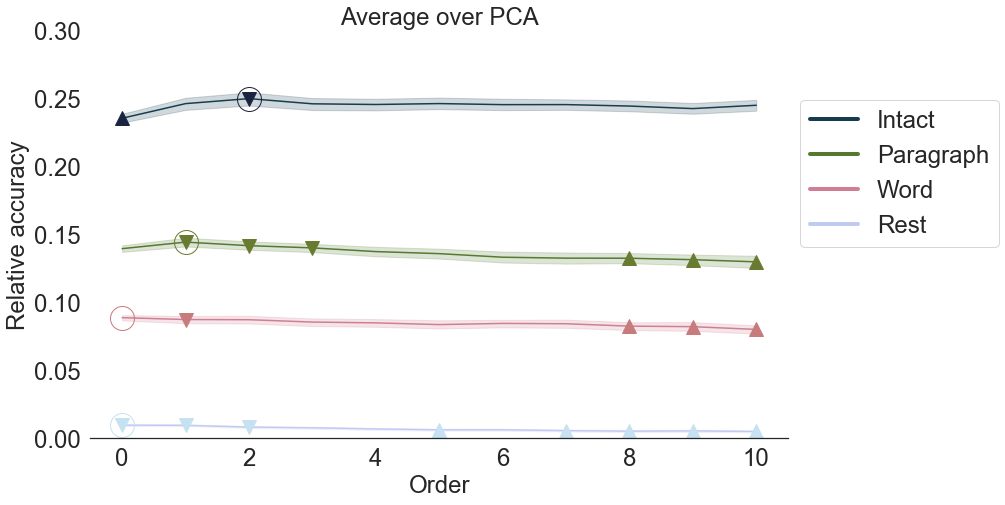

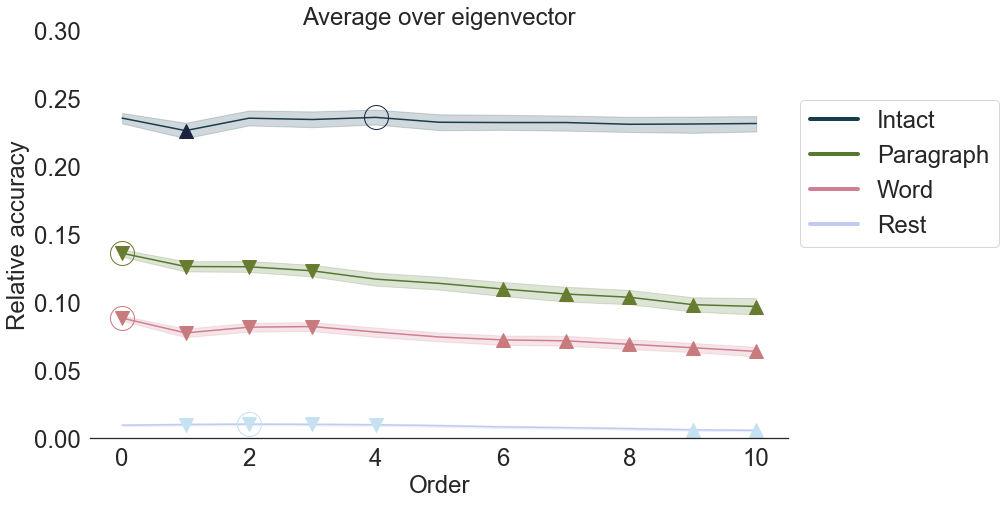

In [93]:

split_by = 'Reduction'

for i in eval(split_by + '_type'):
       
    #outfile = os.path.join(figdir, param_name + '_line_'+ analysis_name + '.pdf')
    outfile=None
    grouped_lineplot(comb_data[comb_data[split_by]==i], 'Level', 'Relative accuracy','Condition', plot_marker=True, sig_lines=True, ymin=0, ymax=.3, title = 'Average over ' + i, outfile=outfile)
    plt.show()
    plt.close()

## Compile and plot weights.  Might not keep the plots. 

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:8: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  
/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


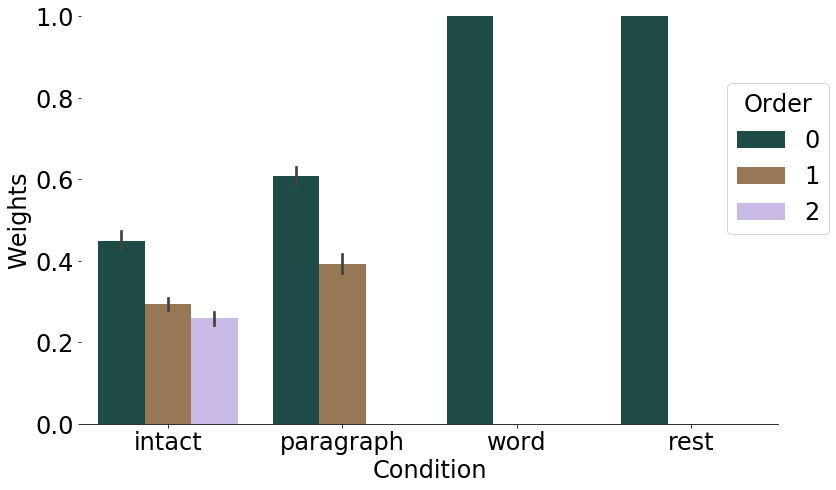

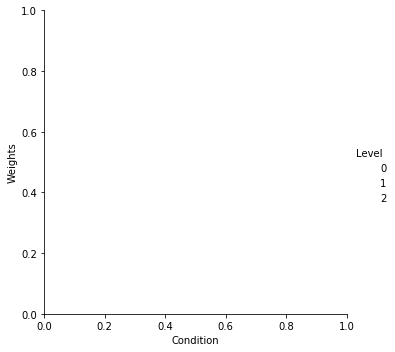

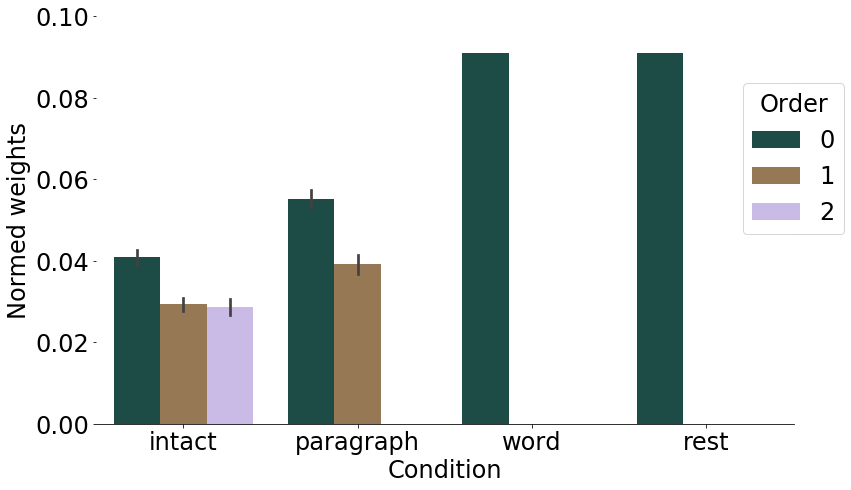

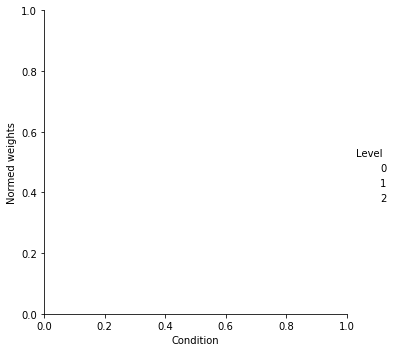

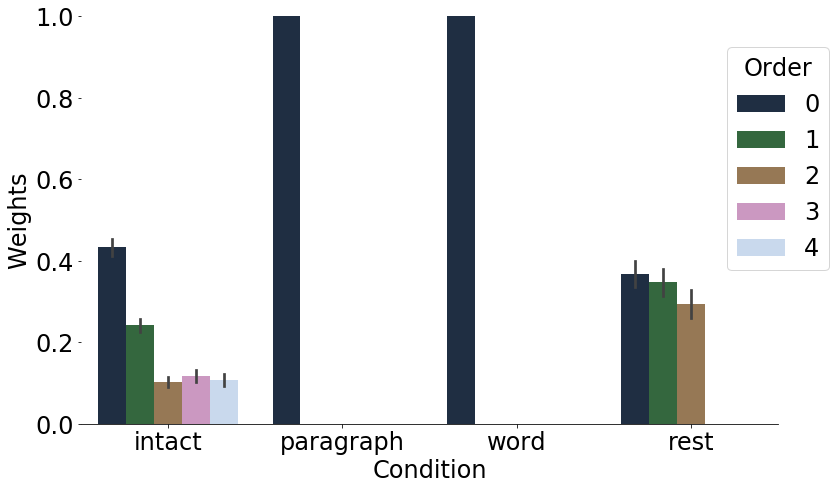

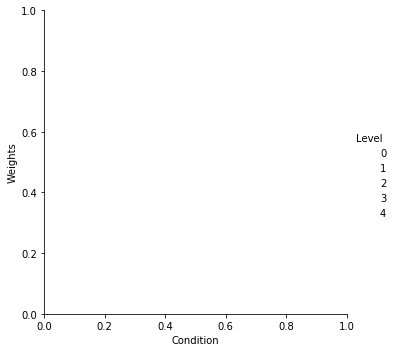

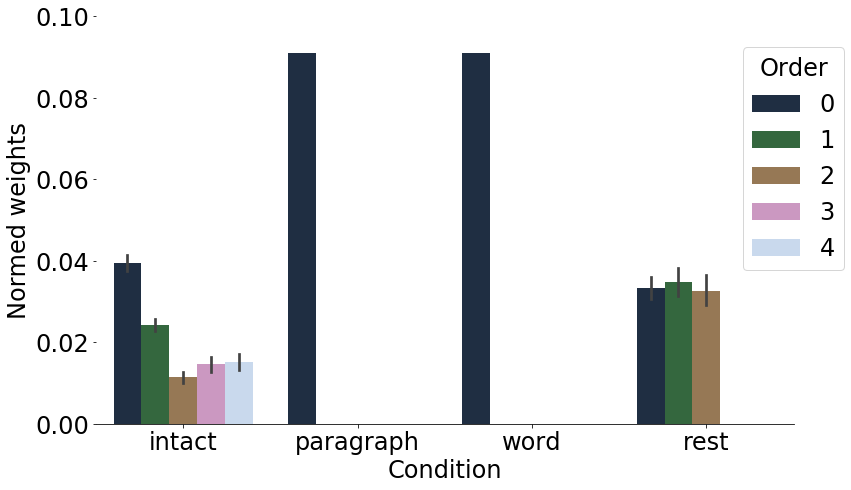

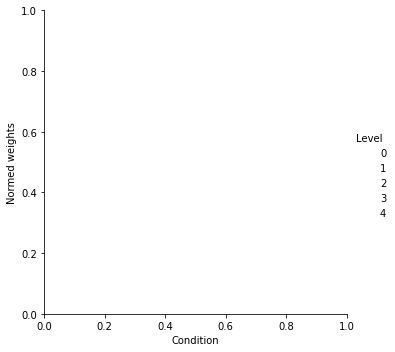

In [18]:

factors = 700
pieman_conds = ['intact', 'paragraph', 'word', 'rest']

split_by = 'Reduction'

weight_melt = pd.DataFrame()

for i in eval(split_by + '_type'):
    new_melt = pd.DataFrame()

    all_data = average_param(pieman_params, pieman_conds)
    max_levels = max_level_bycolumn(comb_data[comb_data[split_by]==i], y='Relative accuracy')
    for p in pieman_params:
        
        param_name = os.path.basename(os.path.splitext(p)[0])
        full_data = combine_param_df(p)
        p_split = param_name.split('_')
        
        if p_split[1] == i:
            
            for e, cond in enumerate(pieman_conds):

                #p_df = comb_data[comb_data['Condition']==cond]
                p_df = full_data[full_data['Condition']==cond]
                max_level = max_levels[e]
                #max_level = 10

                p_df = p_df[p_df['Level'] == max_level]

                for c in np.arange(max_level + 1):
                    
                    melted_temp_df = pd.DataFrame()

                    melted_temp_df['Weights'] = p_df['level_' + str(c)]
                    melted_temp_df['Normed weights'] = p_df['level_' + str(c)]/(11-c)

                    melted_temp_df['Level'] = c

                    melted_temp_df['Condition'] = p_df['Condition']

                    if new_melt.empty:
                        new_melt = melted_temp_df
                    else:
                        new_melt= new_melt.append(melted_temp_df)


    new_melt= new_melt.append(melted_temp_df)

    temp_melt = pd.DataFrame(new_melt.groupby(['Condition', 'Level']).mean()['Weights']).reset_index()

    temp_melt['Reduction'] = i
    
    weight_melt = pd.concat([weight_melt,temp_melt])
    
    p_split = param_name.split('_')

    title = p_split[0] + ' ' + p_split[1] + ' ' + p_split[-2] + ' ' + p_split[-1] 
    #outfile=None
    outfile = os.path.join(figdir, i + '_weights_ave_'+ analysis_name + '.pdf')
    grouped_barplot(new_melt, 'Condition', 'Weights', 'Level', ymin=0, ymax=1, title = '', outfile=outfile)
    outfile = os.path.join(figdir, i + '_norm_weights_ave_'+ analysis_name + '.pdf')
    grouped_barplot(new_melt, 'Condition', 'Normed weights', 'Level', ymin=0, ymax=.1, title = '', outfile=outfile)
    plt.show()
    plt.close()

## Calculate stats comparing each level to every other level and plot

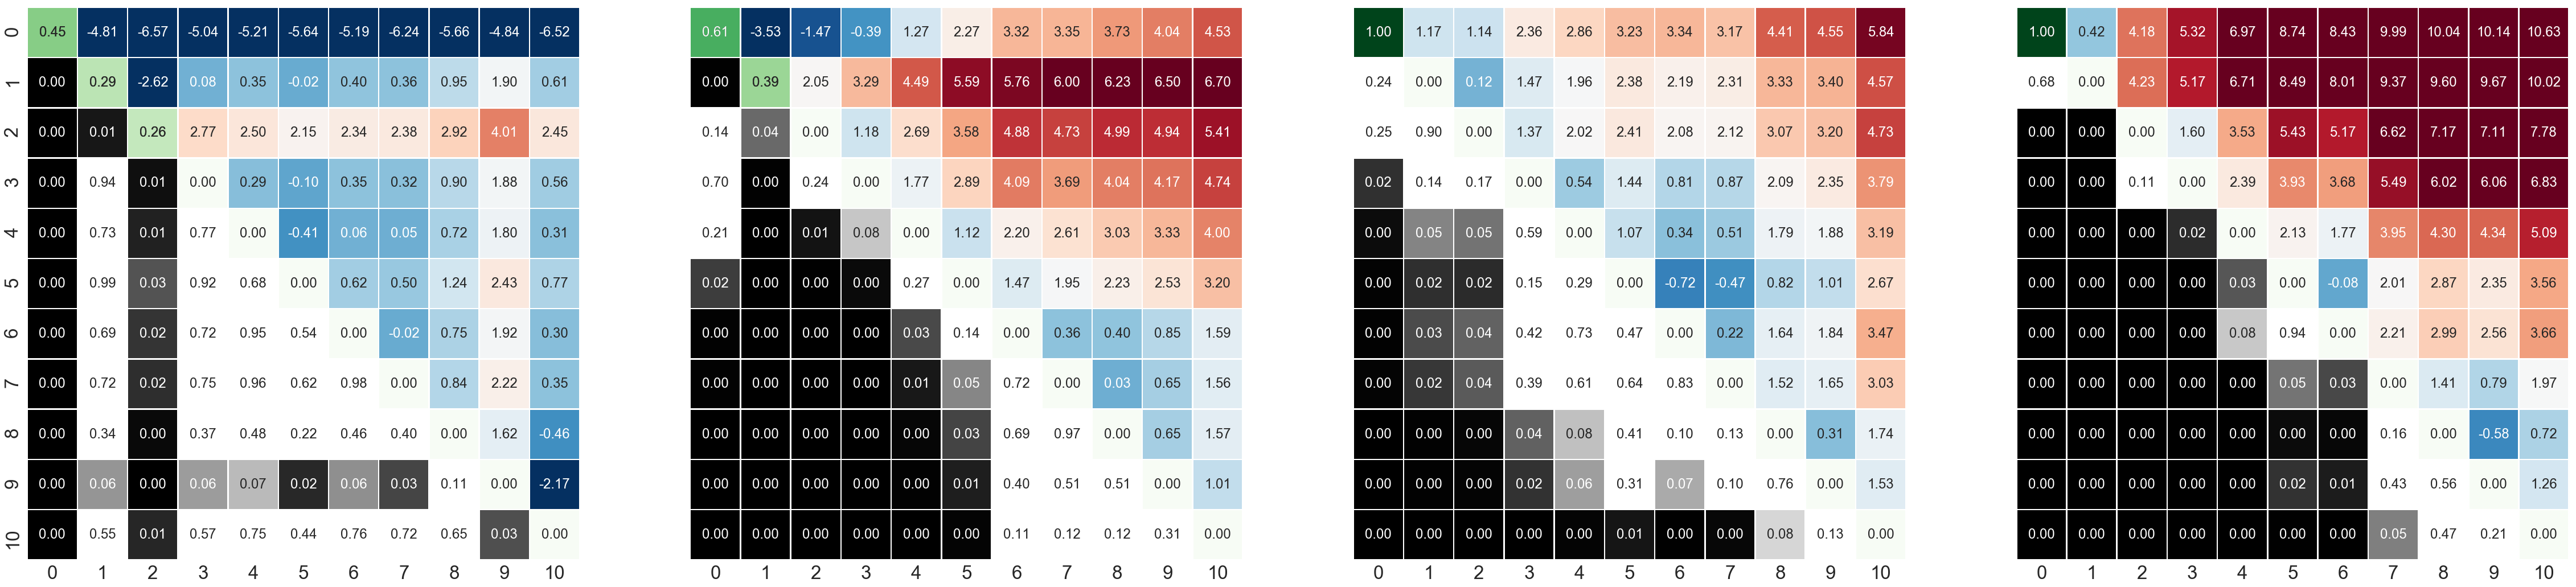

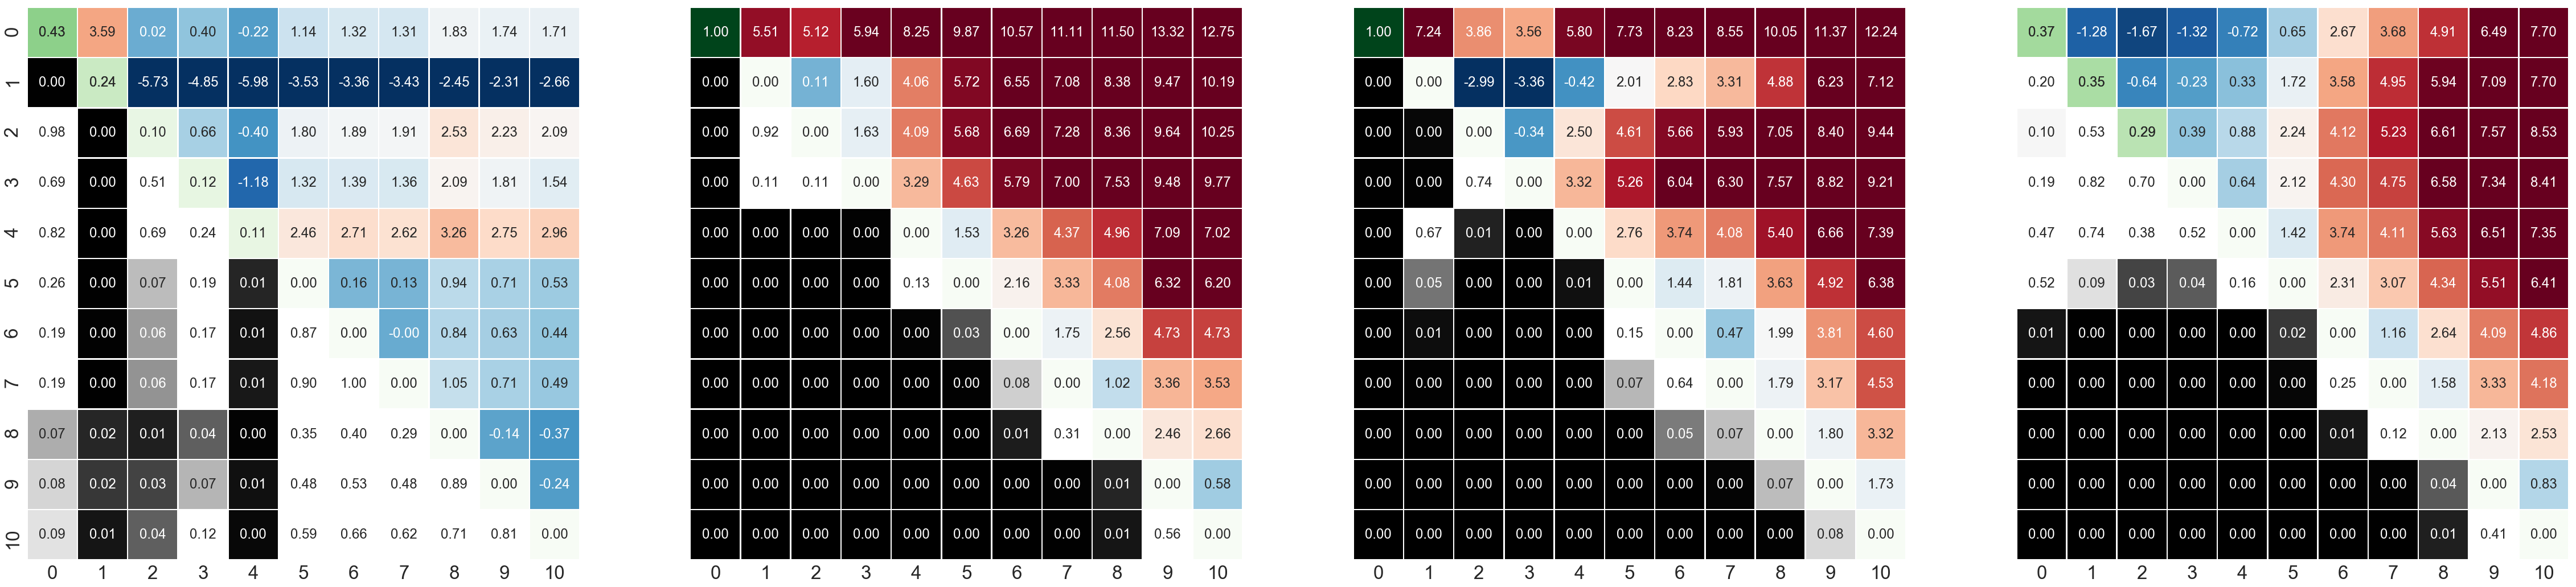

In [81]:
lev_perms = list(range(11))
lev_perms
stat_dict = {}

sns.set(font_scale=3)

split_by = 'Reduction'

for i in eval(split_by + '_type'):

    t_array = np.zeros((11, 11, 4))
    
    fig, axn = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(80,20))
    
    
    for e, ax in enumerate(axn.flat):
        
    
        c = pieman_conds[e]
        parsed_pd = comb_data[(comb_data['Condition']==c)&(comb_data['Reduction']==i)]

        for pair in list(itertools.combinations(lev_perms, r=2)):

            t = stats.ttest_rel(parsed_pd[parsed_pd['Level']==pair[0]]['Relative accuracy'], 
                                parsed_pd[parsed_pd['Level']==pair[1]]['Relative accuracy'])

            t_array[pair[0], pair[1], e] = t.statistic
            t_array[pair[1], pair[0], e] = t.pvalue
            
        temp_diag = weight_melt[(weight_melt['Reduction'] == i) & (weight_melt['Condition'] == c)]
        no_pad = temp_diag['Weights'].values
        with_pad = np.pad(no_pad, (0, 11 - len(no_pad)%1), 'constant')

        np.fill_diagonal(t_array[:, :, e], with_pad)
            
        #fig, ax = plt.subplots(figsize=(10,10)) 
        arr_name = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
        data = t_array[:, :, e]
        df = pd.DataFrame(data, columns=arr_name)

        labels = df
        labels = labels.round(2)
        labels = labels.replace(np.nan,' ', regex=True)

        mask = np.triu(np.ones(df.shape)).astype(np.bool)
        
        sns.heatmap(df, mask=mask, cmap='binary_r',annot=labels, annot_kws={"size": 24},cbar=False, fmt='.2f', square=True, linewidths=1.5, vmin=0, vmax=.1, ax=ax)
        
        mask = np.ones((11, 11))-mask
        sns.heatmap(df, mask=mask, cmap='RdBu_r',annot=labels, annot_kws={"size": 24},cbar=False, fmt='.2f', vmin=-2, vmax=6, linewidths=1.5, ax=ax)
        full_sq = np.ones((11,11))
        np.fill_diagonal(full_sq, 0)
        sns.heatmap(df, mask=full_sq.astype(np.bool), cmap='Greens',annot=labels, annot_kws={"size": 24},cbar=False, fmt='.2f', vmin=0, vmax=1, linewidths=1.5, ax=ax)
        #ax.set_title(c.capitalize(), fontsize=50)
        #ax.set_xticklabels(fontsize = 16)

    
    outfile = os.path.join(figdir, 'stats_heatmaps_' + i + '.pdf')
    plt.savefig(outfile)
    plt.show()

## Make plots

In [82]:
split_by = 'Reduction'

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:8: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  


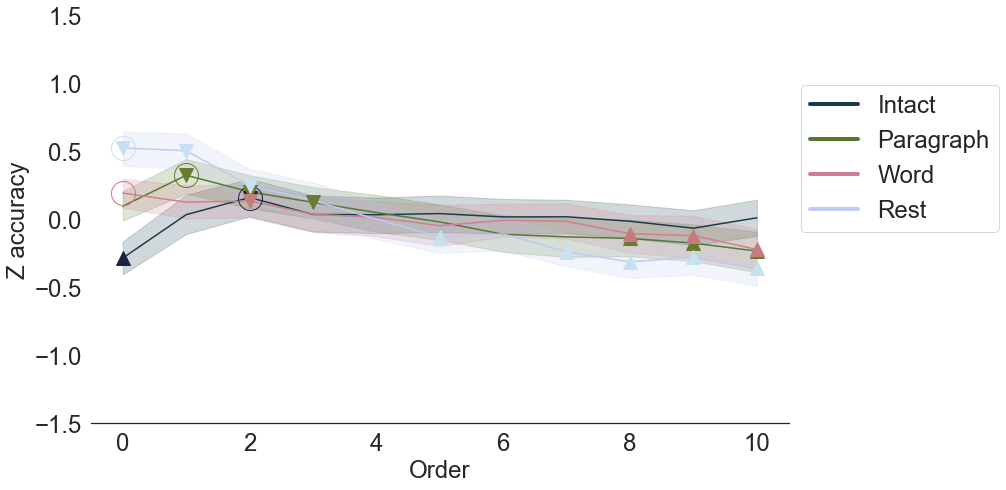

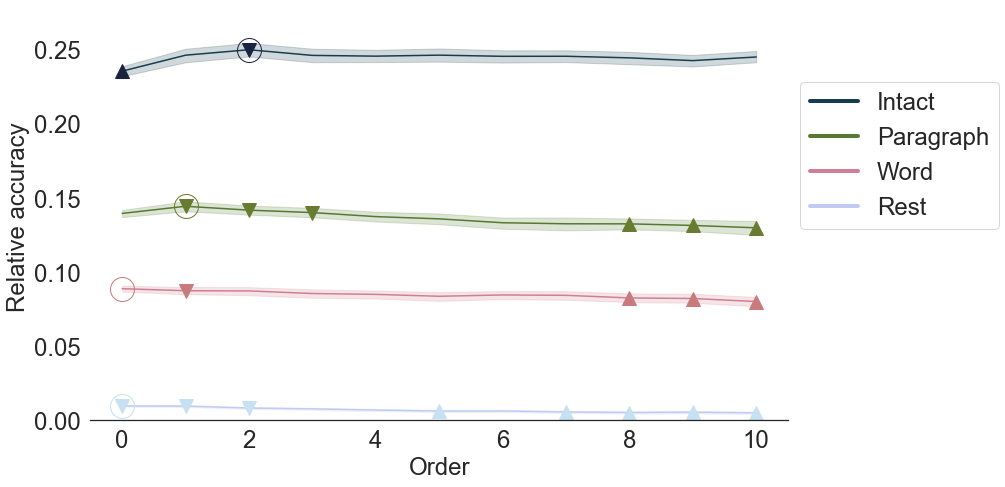

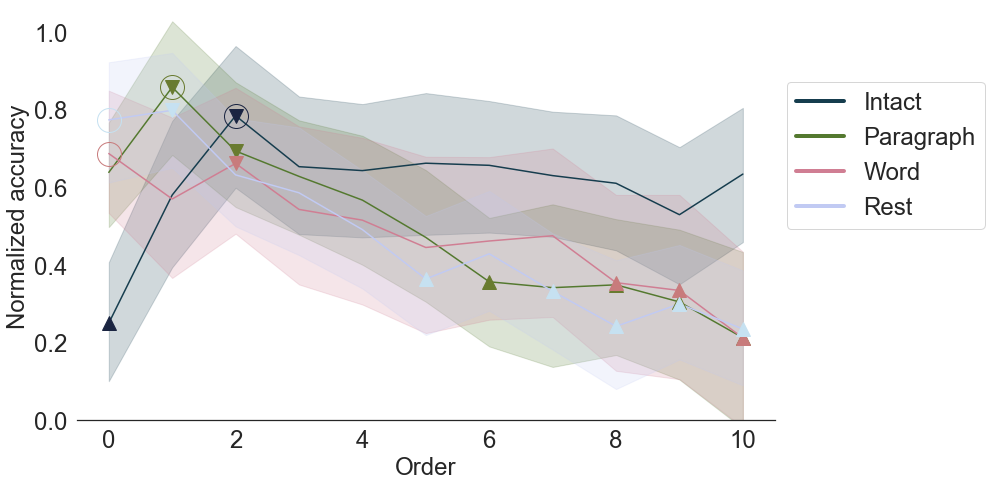

In [102]:
reduction_type = 'PCA'

comb_data = comb_param(pieman_params, pieman_conds)

markers_y = max_level_bycolumn(comb_data[comb_data[split_by]==reduction_type], y='Relative accuracy')

outfile = os.path.join(figdir, reduction_type + '_z_ave_'+ analysis_name + '.pdf')
grouped_lineplot(comb_data[comb_data[split_by]==reduction_type], 'Level', 'Z accuracy','Condition', plot_marker=markers_y, sig_lines=True, ymin=-1.5, ymax=1.5, title = '', outfile=outfile)
plt.show()
plt.close()

outfile = os.path.join(figdir, reduction_type + '_rel_ave_'+ analysis_name + '.pdf')
grouped_lineplot(comb_data[comb_data[split_by]==reduction_type], 'Level', 'Relative accuracy','Condition', plot_marker=markers_y, sig_lines=True, ymin=0, ymax=.275, title = '', outfile=outfile)
plt.show()
plt.close()

outfile = os.path.join(figdir, reduction_type + '_norm_ave_'+ analysis_name + '.pdf')
grouped_lineplot(comb_data[comb_data[split_by]==reduction_type], 'Level', 'Normalized accuracy','Condition', plot_marker=markers_y, sig_lines=True, ymin=0, ymax=1.05, title = '', outfile=outfile)
plt.show()
plt.close()

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:8: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  


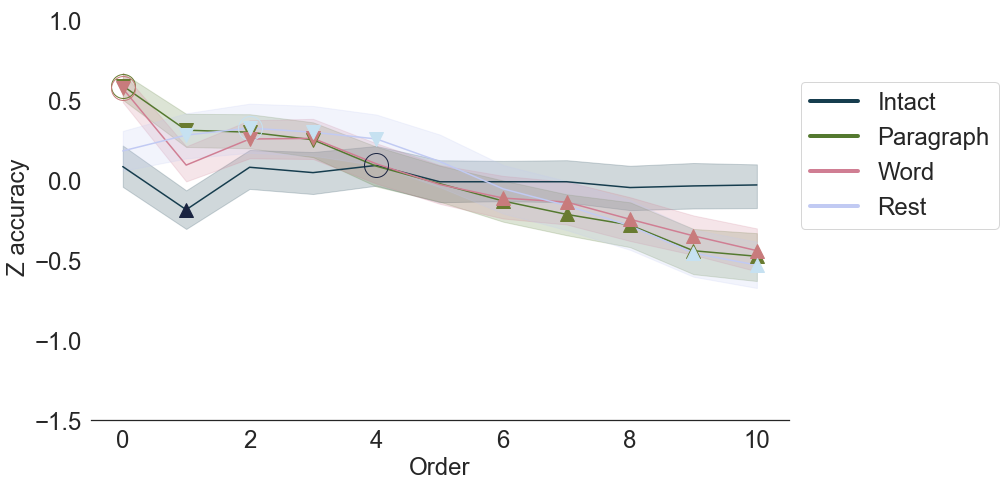

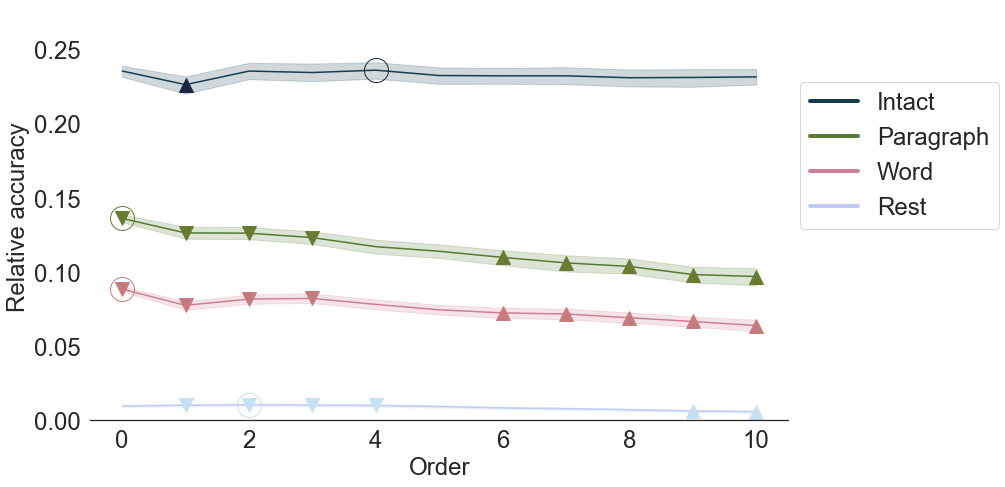

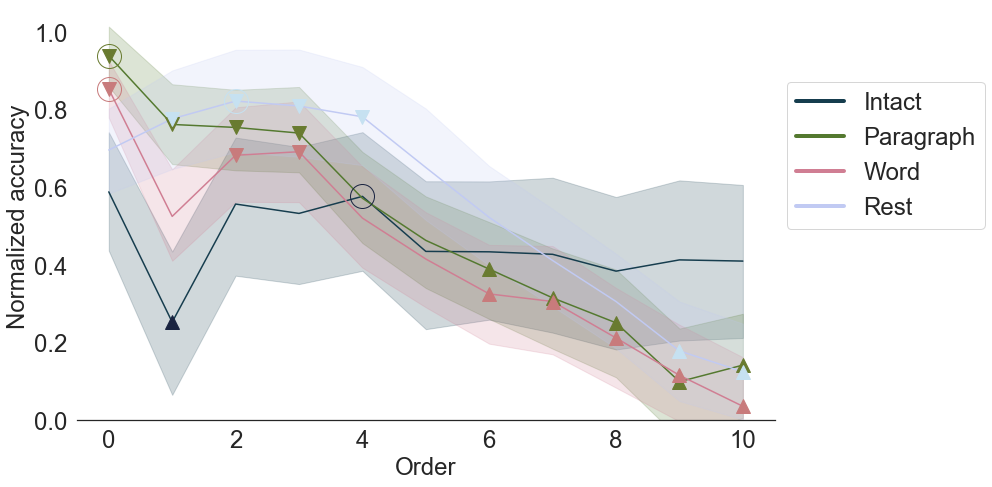

In [103]:
reduction_type = 'eigenvector'

comb_data = comb_param(pieman_params, pieman_conds)

markers_y = max_level_bycolumn(comb_data[comb_data[split_by]==reduction_type], y='Relative accuracy')

outfile = os.path.join(figdir, reduction_type + '_z_ave_'+ analysis_name + '.pdf')
grouped_lineplot(comb_data[comb_data[split_by]==reduction_type], 'Level', 'Z accuracy','Condition', plot_marker=markers_y, sig_lines=True, ymin=-1.5, ymax=1.05, title = '', outfile=outfile)
plt.show()
plt.close()

outfile = os.path.join(figdir, reduction_type + '_rel_ave_'+ analysis_name + '.pdf')
grouped_lineplot(comb_data[comb_data[split_by]==reduction_type], 'Level', 'Relative accuracy','Condition', plot_marker=markers_y, sig_lines=True, ymin=0, ymax=.275, title = '', outfile=outfile)
plt.show()
plt.close()

outfile = os.path.join(figdir, reduction_type + '_norm_ave_'+ analysis_name + '.pdf')
grouped_lineplot(comb_data[comb_data[split_by]==reduction_type], 'Level', 'Normalized accuracy','Condition', plot_marker=markers_y, sig_lines=True, ymin=0, ymax=1.05, title = '', outfile=outfile)
plt.show()
plt.close()